### Learning prior iteratively

In [1]:
# setup the environment
import nengo
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
% matplotlib inline

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

import seaborn as sns
sns.set_context("talk")

In [2]:
# assuming that maximum possible age is 120 yrs
max_age = 120

# our function domain is thetas (i.e., age from 1 to 120)
# Remember thetas is same as Z in our plate notation (shown later)
# We are also assuming discrete values for age, because people 
# usually report integers for age when asked to predict.
thetas = np.linspace(start=1, stop=max_age, num=max_age)

# compute likelihood 
def likelihood(x):
    x = int(x)
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

# computer prior
def skew_gauss(skew, loc, scale):
    return [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 

# computer posterior
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    post = post/sum(post)
    return post

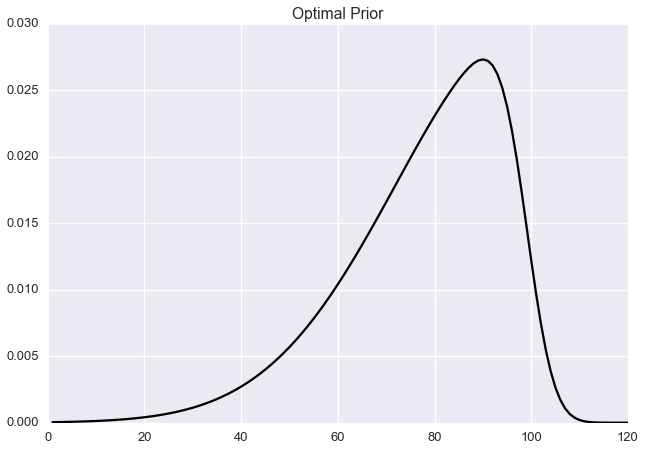

In [3]:
# Prior which is the actual solution and
# is used to generate the observed data 

# prior parameters
#skew = -4    # fixed parameter
#loc = 95     # to be estimated
#scale = 26   # fixed parameter

skew = -6    # fixed parameter
loc = 99    # to be estimated
scale = 27   # fixed parameter


prior = skew_gauss(skew, loc, scale)
plt.figure()
plt.title("Optimal Prior")
plt.plot(thetas, prior, 'k')


mean = st.skewnorm.mean(skew, loc, scale)
std_dev = st.skewnorm.std(skew, loc, scale)
#print "Mean: ", mean
#print "Std. deviation: ", std_dev

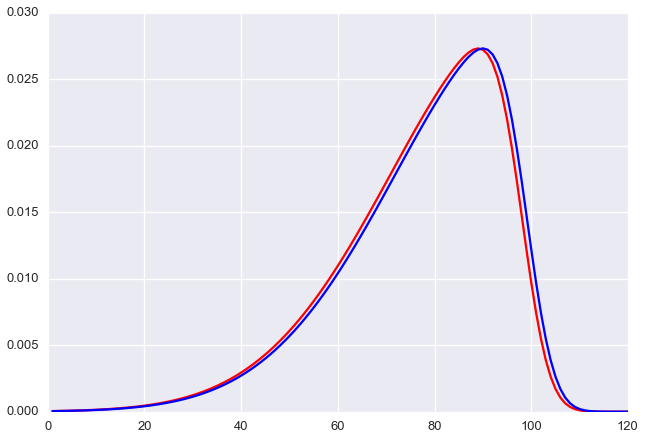

In [4]:
# Showing that the difference between priors with 
# loc = 95 and 96 is not too much and hence the fractional 
# values between any two integer values of loc can be ignored
# to limit the search space and simplify the problem.
plt.figure()
prior = skew_gauss(skew, 98, 27)
plt.plot(thetas, prior, 'r')
prior = skew_gauss(skew, 99, 27)
plt.plot(thetas, prior, 'b')

Mean:  -0.249769032776
Std. deviation:  16.6567498647
Mean:  120.750230967
Std. deviation:  16.6567498647


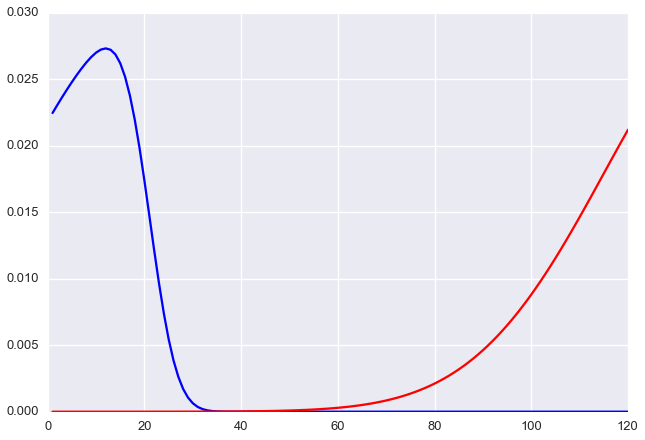

In [5]:
# The Prior is conditioned on three parameters, however
# we assume that two of the parameters are fixed and estimate
# only one parameter 'loc'. Thus the hyperparameter alpha to  
# be is estimated is 'loc' in this case.

# Check the range of values we should be searching over.
# We know that the mean age should be between 0 to 120 since 
# we are assuming max age is 120. Hence, we should search over
# the range of values of 'loc' that give mean between 0 to 120.

# lower bound
loc_r = 21 

prior = skew_gauss(skew, loc_r, scale)
plt.figure()
plt.plot(thetas, prior, 'b')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# upper bound
loc_r = 142 

prior = skew_gauss(skew, loc_r, scale)
plt.plot(thetas, prior, 'r')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# Thus the search range for 'loc' is 20 to 141 since priors
# beyond these values wouldn't make sense for this problem
# The hypothesis is that people are able to constrain their
# search space based on the knowledge of min and max ages
# they observe in the world around them.

# Thus loc has discrete values from 20 - 141. 
# Remember alpha = loc 
upper = 142 
lower = 21
alpha = np.arange(lower, upper+1, 1)   # possible values of alpha
M = upper-lower+1  # number of discrete possibilities of alpha

The two stage hierarchical bayes model is summarised in the <a href="https://en.wikipedia.org/wiki/Plate_notation">Plate notation</a> as follows:
![](http://i.imgur.com/gmLKIjJ.png)

The data is generated in the forward direction ($\alpha \longrightarrow Z \longrightarrow X$). Then only $X$ is accessible to the model, along with the "knowledge" of how this was generated. The actual parameters for $Z$ and $\alpha$ are hidden from the model. The task is then to infer the most likely $Z$ and $\alpha$ given the observed sample $X$.

In [6]:
# These two functions are used to generate the sample X. 

# Function to sample discrete random values from a skewed gaussian distribution
def randn_skew(n_samples, skew=0.0, loc=0.0, scale=1.0):
    probs = skew_gauss(skew, loc, scale)
    probs /= sum(probs)   # to make sure the sum is exactly 1 and not 0.999
    samples = np.random.choice(thetas, size=n_samples, replace=True, p=probs)   
    samples = list(samples)  #convert ndarray to a python list
    return samples

# Function to draw samples X for the given number of trials
def draw(n_trials, n_samples):
    x_vector = []
    for i in np.arange(n_trials):
        z_vector = randn_skew(n_samples=n_samples, skew=skew, loc=loc, scale=scale)  # generating Z from alpha
        x_vector.append(np.asarray([np.random.randint(low=1, high=th+1) for th in z_vector]))   # X from Z
    return x_vector

In [7]:
# Compute the prior for all values of alpha
# this is our search space
prior = np.zeros((len(alpha), max_age))
i = 0
for k in alpha:
    prior[i, :] =  skew_gauss(skew, alpha[i], scale)    # p(Z)
    prior[i, :] = prior[i, :]/sum(prior[i, :])  # normalize prior 
    i = i+1
    
    
# priors conditioned on alpha: p(Z/A)    
pZA = prior
logpZA = np.log(pZA)    

In [8]:
from nengo.utils.progress import ProgressTracker

# Function to compute the likelihood of each  
# 'x' in the Sample X (x_vector)
def compute_lik(x_vector):
    lik = np.zeros((len(x_vector), max_age))
    i = 0
    count = 0
    for obs in x_vector:
        if int(obs) > 120:
            obs = 120   
            count = count + 1 
        lik[i,:] = likelihood(obs)    #pXZ
        i = i+1
    #print "Count samples above 120: ", count    
    return lik    

    
estimate_list = []
# Online EM where the stored terms are decayed away
# Adding iterations for each example (1) similar to STM cycling
# around hippocampus while being consolidated in the LTM.
# 1) Inner terations: As each example comes in, we update the stored 
# terms and  iterate 'num_inner_iter' times for each individual example.
# 2) Outer Iterations: After all examples have been received, we repeat the 
# entire process/iterate by reusing the same set of examples 'num_iter' times.
# This might be similar to refelcting on past experiences etc.
def stepwise_em_iterative(x, num_iter=5, num_inner_iter=1):
    _pXZ = compute_lik(x)
    a =  np.random.randint(lower, upper) - lower 
    #print "start: ", a           
    best_a = None
    best_utility = float('-inf')
    flag = 0
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far
    beta = 0.65        # 1 gave 40% and 0.5 gave 98% accuracy
    _pXZ_list = list(enumerate(_pXZ))

    iterations = 0
    current_guess = -1
    guess_counter = 0
    
    for r in range(num_iter):
        np.random.shuffle(_pXZ_list) 
        flag = 0
        for i, p in _pXZ_list:
            for _ in range(num_inner_iter): 
                L = np.zeros(M)   
                pxz = p * pZA[a, :]
                L += (pxz / np.sum(pxz)).dot(logpZA.T)

                gamma = np.power(float(k+2), -beta)  
                k = k + 1

                S = gamma*L + (1-gamma)*S
                max_a = a = np.argmax(S)                
                estimate_list.append(max_a + lower)
                
                if current_guess == max_a:
                    guess_counter = guess_counter + 1
                else:
                    guess_counter = 0
                    
                if guess_counter >= 20000:
                    #print "Total interations: ", iterations
                    return max_a + lower
                    
                
                current_guess = max_a
                iterations = iterations + 1
                
                #print max_a + lower         
    #print "Total interations out: ", iterations
    return max_a + lower


'''
if L[max_a] > best_utility:
    best_a = max_a
    best_utility = L[max_a]

if prev_max == max_a:
    L[a] = np.min(L)
    a = np.argmax(L)
    if a == best_a:
        break 
prev_max = max
'''


# Accuracy defined based on +/2 withing the optimal value
def grade_solution(f, n_trials, n_samples, name=None, plot=True):
    X = draw(n_trials, n_samples)
    
    correct = 0
    diff = np.empty(n_trials)
    with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
    with ProgressTracker(n_trials, True, name) as progress:
        for j in range(n_trials):
            #print "X, alpha: ", X[j], alpha[j]
            a_est = f(X[j])
            #if a_est == loc:
            if a_est >= loc-2 and a_est <= loc+2: 
                correct += 1
            diff[j] = a_est-loc #np.abs(a_est-loc)
            progress.step()
    acc = correct / float(n_trials)
    #print ("%s (Accuracy = %.3f)" % (name, acc))
    
    if plot:
        plt.figure()
        plt.title("%s (Accuracy = %.3f)" % (name, acc), fontsize=18)
        plt.plot(diff, 'o')
        sns.set_style('darkgrid')
        plt.xlabel("number of trials", fontsize=18)
        plt.ylabel("Diff. between estimate and ideal alpha", fontsize=18)
        sns.despine(offset=10)
        plt.show()
    return acc

There are two ways of evaluating these different algorithms. One is accuracy i.e., number of times the algorithm converges to the optimal value which is 95. Second, how close the convergence values are to the optimal value. I think its reasonable if the algorithm converges to values close to the optimal value, since they will lead to priors which are close, and hence can lead to similar samples $X$.

Initializing finished in 0:00:01.                                               
Stepwise Iterative EM finished in 0:02:03.                                      


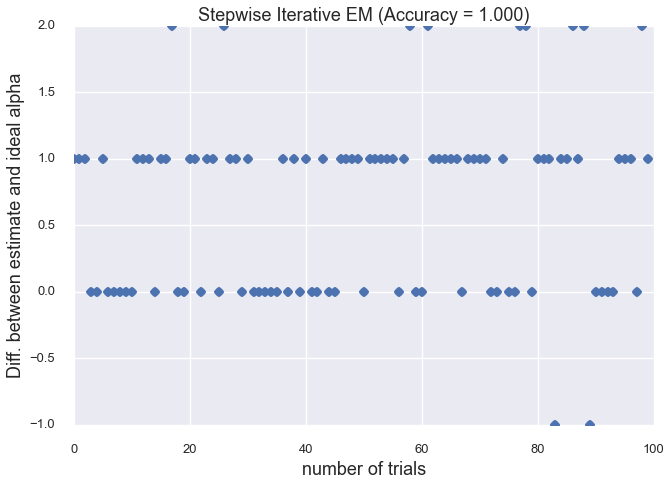

1.0

In [9]:
estimate_list = []
grade_solution(stepwise_em_iterative, n_trials=100, n_samples=5000, name="Stepwise Iterative EM")

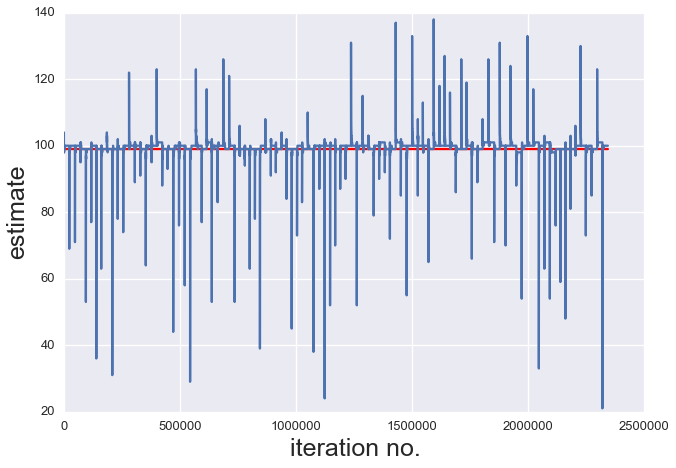

In [16]:
plt.figure()
plt.plot(np.arange(len(estimate_list)), 99*np.ones((len(estimate_list))), 'r')
plt.plot(np.arange(len(estimate_list)), estimate_list)
#plt.xlim(800200 - 800, 800200)
#plt.xlim(430000, 488000)
#plt.ylim(80, 120)
plt.xlabel("iteration no.", fontsize=25)
plt.ylabel("estimate", fontsize=25)

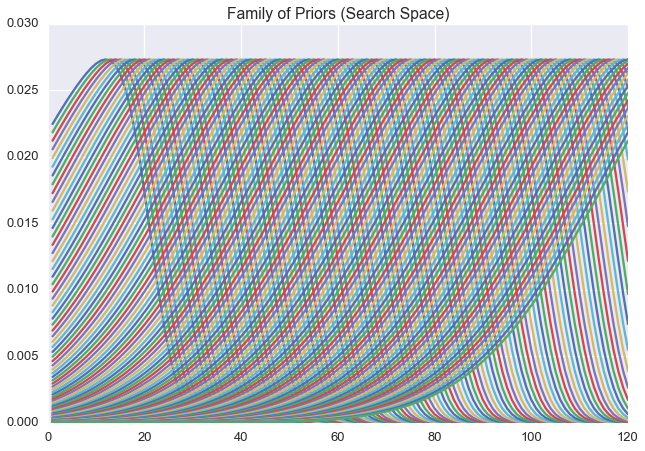

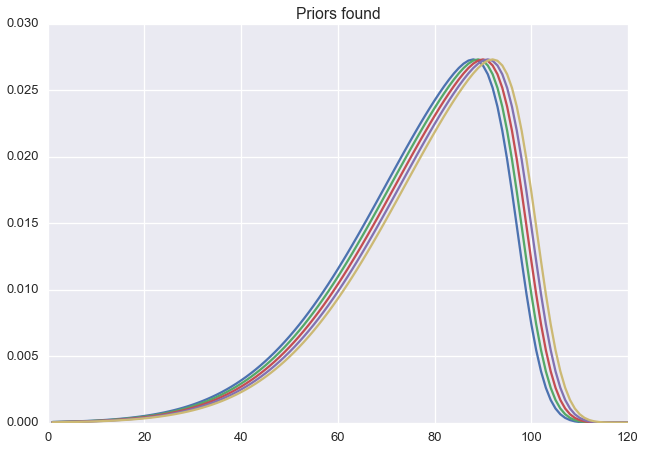

In [14]:
# Plot the search space - priors we are searching over
plt.figure()
plt.title("Family of Priors (Search Space)")
for loc_value in alpha:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)
    

# Plot the priors with value of loc within +/-3 of 95
plt.figure()
plt.title("Priors found")    
loc_list = [loc-2, loc-1, loc, loc+1, loc+2]
for loc_value in loc_list:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)